In [135]:
import yfinance as yf
import pandas as pd
import polars as pl
import os
import re
import urllib.parse
from datetime import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math 

In [136]:
COMPANY_NAME_LIST = ['Apple%2520Inc.%2520(AAPL)%2520(CIK%25200000320193)', 'MICROSOFT%2520CORP%2520(MSFT)%2520(CIK%25200000789019)', 
                     'BigCommerce%2520Holdings%252C%2520Inc.%2520(BIGC)%2520(CIK%25200001626450)', 'ROKU%252C%2520INC%2520(ROKU)%2520(CIK%25200001428439)', 
                     'JPMORGAN%2520CHASE%2520%2526%2520CO%2520(JPM%252C%2520AMJ%252C%2520AMJB%252C%2520JPM)%2520(CIK%25200000019617)', 'VISA%2520INC.%2520(V)%2520(CIK%25200001403161)', 
                     'Block%252C%2520Inc.%2520(SQ%252C%2520BSQKZ)%2520(CIK%25200001512673)', 'Robinhood%2520Markets%252C%2520Inc.%2520(HOOD)%2520(CIK%25200001783879)', 
                     'JOHNSON%252C%252C%2520JOHNSON%2520(JNJ)%2520(CIK%25200000200406)', 'PFIZER%2520INC%2520(PFE)%2520(CIK%25200000078003)', 
                     'Moderna%252C%2520Inc.%2520(MRNA)%2520(CIK%25200001682852)', 'Teladoc%2520Health%252C%2520Inc.%2520(TDOC)%2520(CIK%25200001477449)', 
                     'EXXON%2520MOBIL%2520CORP%2520(XOM)%2520(CIK%25200000034088)', 'CHEVRON%2520CORP%2520(CVX)%2520(CIK%25200000093410)', 
                     'FIRST%2520SOLAR%252C%2520INC.%2520(FSLR)%2520(CIK%25200001274494)', 'PLUG%2520POWER%2520INC%2520(PLUG)%2520(CIK%25200001093691)', 
                     'GENERAL%252CELECTRIC%2520CO%2520(GE)%2520(CIK%25200000040545)', '3M%2520CO%2520(MMM)%2520(CIK%25200000066740)', 
                     'CATERPILLAR%2520INC%2520(CAT)%2520(CIK%25200000018230)', 'FASTENAL%2520CO%2520(FAST)%2520(CIK%25200000815556)']

Collect scores from hard memory

In [137]:
df_dict_scores = {}
regex = r"\\([^\\]+)_full_doc_sen_score_df\.parquet$"

for root, dirs, files in os.walk(r'C:\Users\310\Desktop\Progects_Py\Parsim-sec\src\Analysis\data\full_10_Q_scores'):
    for file in files:
            
            file_path = os.path.join(root, file)
            ticker = re.search(regex, file_path).group(1)
            
            df = pl.read_parquet(file_path)

            df_dict_scores[ticker] = df 

In [138]:
df = df_dict_scores["GE"]
tic_sym = "GE"
df

2019-04-30,2019-07-31,2019-10-30,2020-02-24,2020-04-29,2020-07-29,2020-10-28,2021-02-12,2021-04-27,2021-07-27,2021-10-26,2022-02-11,2022-04-26,2022-07-26,2022-10-25,2023-02-10,2023-04-25,2023-07-25,2023-10-24,2024-02-02,2024-04-23
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
-12.849008,-10.494805,-14.107974,-30.133511,-13.439952,-12.999193,-14.971735,-35.735787,-10.841224,-10.056447,-8.511603,-30.035251,-3.151193,-2.180779,-4.783131,-26.817862,-4.257227,-5.295587,-3.992991,-29.066429,-20.433151
-84.0,-68.0,-77.0,-168.0,-81.0,-73.0,-84.0,-195.0,-73.0,-65.0,-55.0,-169.0,-40.0,-28.0,-38.0,-160.0,-35.0,-43.0,-38.0,-161.0,-121.0
-0.367816,-0.335992,-0.348473,-0.29972,-0.366922,-0.363445,-0.350427,-0.325886,-0.354839,-0.307278,-0.264813,-0.282203,-0.256506,-0.23964,-0.295455,-0.298453,-0.230088,-0.289176,-0.244094,-0.27239,-0.361179
0.457193,0.434381,0.430875,0.445714,0.463025,0.404468,0.414253,0.446668,0.456579,0.441176,0.443396,0.439415,0.40296,0.387564,0.37332,0.429854,0.469191,0.416539,0.409936,0.437905,0.408483


This is support func to find end prices and their dates. It takes as an arguments starting index, which is the nuber of row of hist dataframe and this hist dataframe itself. Hist dataframe contain daily OHLC data for particular ticker (company). 

It also cheks wether index of end price is in hist, meaning that if this particular report was released very resently (less then 8 trading days ago) it will append none values for end prices out of range of hist df instead of raising an error.

It returns lists of end prices and corresponding dates (none values for prices and their dates, if they are out of range of hist df).

In [139]:
def find_end_price(start_index, hist):
    end_price_list = []
    end_price_date_list = []
    
    for x in range(2, 8):
        idx = start_index + x
        if idx < len(hist):
            end_price_list.append(hist.iloc[idx]['Open'])
            end_price_date_list.append(hist.index[idx])
        else:
            end_price_list.append(None)
            end_price_date_list.append(None)
    return end_price_list, end_price_date_list

This is support func to calc the regular returns. It takes start price and end_price_list as an arguments. It checks whether value in end price list is none and if it is, it appends none in returns list, instead of raising an error. So we are shure that all end price lists are of the same length, but for those prices that are not found in historical data we have none values for returns.

In [140]:
def regular_returns(start_price, end_price_list):
    retuns = []
    for end_price in end_price_list:
        if end_price is None:
            retuns.append(None)
        else:
            ret = (end_price - start_price) / start_price * 100
            retuns.append(ret)
    return retuns

This is the support func that calc SnP500 returns. It takes_start date and end_price_date_list as and arguments and then calculate returns for this timeframes. This func also checks whether value of end_price_date_list is none (meaning that it is not found in historical data), and if it is, func will append none instead of raising an error.

Now we are shure that list of snp_returns will be of equal length for all report release dates and all time frames, but for those returns that cannot be calculates due to non existent end prices we will have nones 

In [141]:
def snp_500_return(start_date, end_price_date_list):
    snp500_ticker = yf.Ticker("^GSPC")
    snp_price = snp500_ticker.history(period="5y", auto_adjust=True)

    snp_returns = []

    for end_date in end_price_date_list:
        if end_date is None:
            snp_returns.append(None)

        else: 
            start_index = snp_price.index.get_loc(start_date)
            start_price = snp_price.iloc[start_index]['Open']
    
            end_index = snp_price.index.get_loc(end_date)
            end_price = snp_price.iloc[end_index]['Open']
    
            ret = (end_price - start_price) / start_price * 100
            
            snp_returns.append(ret)

    return snp_returns

This is suppurt function that retrive the end quarter price. It take as an argument hist - historical price dataframe, date_str - the date of release of this particular report, df - company dataframe, with cols named with dates of releases of corresponding reports.

It takes the release date for current report and checks whether it is the last date in time series or not. If it is (this mean that we are are realy close to the end of hist df) we consider the end of hist df as the end of quarter. if it is not, we take next date in company df (which is the date of releas of the next quarterly report) and see its open price, this is pricisely the end of the quarter.

In [142]:
def find_end_quarter(hist, date_str, df):

    col_names = df.columns
    current_index = col_names.index(date_str)

    if current_index < len(col_names) - 1:

        next_date = col_names[current_index + 1]

        next_date_time_stemp = pd.Timestamp(next_date, tz='America/New_York')

        while next_date_time_stemp not in hist.index:

            next_date_time_stemp += pd.Timedelta(days=1)
    
        end_quarter_index = hist.index.get_loc(next_date_time_stemp)
        end_quarter_price = hist.iloc[end_quarter_index]['Open']
        end_quarter_date = hist.index[end_quarter_index]

    else:
        end_quarter_price = hist.iloc[-1]['Open']
        end_quarter_date = hist.index[-1]

    return end_quarter_price, end_quarter_date

This is a func that takes as an input a key-value pair from df_dict_scores and calculate 2-days, 3-days, 4-days, 5-days, 6-days, 7-days and full quarter excess returns for it (S&P500 is the benchmark). It stores the result as a polars df with dates of starting of the period as col names and corresponding returns as col values (seven in each: starting from 2-days down to 7-days and full quarter) - 

In [143]:
def computing_returns(tic_sym, df):

    company_ticker = yf.Ticker(tic_sym)
    hist = company_ticker.history(period="5y")
    
    returns = {}

    for date_str in df.columns:

        start_date = pd.Timestamp(date_str, tz='America/New_York')

        while start_date not in hist.index:

            start_date += pd.Timedelta(days=1)

        start_index = hist.index.get_loc(start_date)

        start_price = hist.iloc[start_index]['Open']

        end_price_list, end_price_date_list = find_end_price(start_index, hist)

        if None not in end_price_list:
            end_quarter_price, end_quarter_date = find_end_quarter(hist, date_str, df)
        else:
            end_quarter_price = None
            end_quarter_date = None
        
        # additional check if end of quarter is withing 8 days horison, and if it is, to avoid double counting we append none instead of last value of hist df
        if end_quarter_price != end_price_list[-1]:

            end_price_list.append(end_quarter_price)
            end_price_date_list.append(end_quarter_date)
        else:
            end_price_list.append(None)
            end_price_date_list.append(None)
        
        reg_returns = regular_returns(start_price, end_price_list)
        snp_returns = snp_500_return(start_date, end_price_date_list)

        excess_returns = [a - b if a is not None and b is not None else None for a, b in zip(reg_returns, snp_returns)]

        returns[date_str] = excess_returns

    returns = pl.DataFrame(returns)
    
    return returns


In [144]:
df = df_dict_scores["GE"]
tic_sym = "GE"
df

2019-04-30,2019-07-31,2019-10-30,2020-02-24,2020-04-29,2020-07-29,2020-10-28,2021-02-12,2021-04-27,2021-07-27,2021-10-26,2022-02-11,2022-04-26,2022-07-26,2022-10-25,2023-02-10,2023-04-25,2023-07-25,2023-10-24,2024-02-02,2024-04-23
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
-12.849008,-10.494805,-14.107974,-30.133511,-13.439952,-12.999193,-14.971735,-35.735787,-10.841224,-10.056447,-8.511603,-30.035251,-3.151193,-2.180779,-4.783131,-26.817862,-4.257227,-5.295587,-3.992991,-29.066429,-20.433151
-84.0,-68.0,-77.0,-168.0,-81.0,-73.0,-84.0,-195.0,-73.0,-65.0,-55.0,-169.0,-40.0,-28.0,-38.0,-160.0,-35.0,-43.0,-38.0,-161.0,-121.0
-0.367816,-0.335992,-0.348473,-0.29972,-0.366922,-0.363445,-0.350427,-0.325886,-0.354839,-0.307278,-0.264813,-0.282203,-0.256506,-0.23964,-0.295455,-0.298453,-0.230088,-0.289176,-0.244094,-0.27239,-0.361179
0.457193,0.434381,0.430875,0.445714,0.463025,0.404468,0.414253,0.446668,0.456579,0.441176,0.443396,0.439415,0.40296,0.387564,0.37332,0.429854,0.469191,0.416539,0.409936,0.437905,0.408483


In [145]:
computing_returns(tic_sym, df)

2019-04-30,2019-07-31,2019-10-30,2020-02-24,2020-04-29,2020-07-29,2020-10-28,2021-02-12,2021-04-27,2021-07-27,2021-10-26,2022-02-11,2022-04-26,2022-07-26,2022-10-25,2023-02-10,2023-04-25,2023-07-25,2023-10-24,2024-02-02,2024-04-23
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.940701,-4.57253,2.70626,0.87601,1.541958,-11.926102,-0.800972,3.593499,-2.797525,-0.760666,-1.894788,0.66832,-6.423493,5.144775,0.805575,0.21343,-3.596363,-0.019752,2.060124,0.967731,0.343106
-0.442636,-5.097688,5.253726,-3.164995,-2.143938,-14.051642,1.251408,3.66098,-2.753713,-0.793922,-0.638799,2.201697,-8.211512,1.372226,2.021194,0.984376,-4.805336,0.667729,0.326292,1.196205,0.905228
0.523536,-4.618141,10.305676,-4.425625,-4.28917,-14.675319,2.050537,2.473785,-2.014988,-1.809928,-0.697376,2.457382,-9.335523,1.169089,1.53765,2.338578,-3.391019,-0.702868,-0.90291,0.768599,1.579864
-0.461543,-7.043549,10.595442,4.591412,-5.975391,-14.524476,0.48262,6.451623,-0.965301,-5.503729,-0.208382,2.094747,-6.768387,4.159919,2.052851,3.232012,-2.227254,-1.226399,0.135025,0.85115,2.140489
-1.329892,-7.638257,11.941536,1.182977,-7.903993,-12.415207,1.572781,11.824766,-2.251341,-4.519513,-0.75663,-2.592296,-5.691211,3.605813,2.712954,2.053055,0.03265,-1.242739,-1.661395,0.781553,2.999662
0.22906,-9.147199,13.460601,1.114322,-6.705947,-13.510506,1.828739,13.152203,-1.617796,-3.243062,-1.735846,-1.257587,-6.376576,1.802583,4.235436,3.319419,0.612204,-0.994508,-2.720633,2.193602,1.848544
1.621571,-9.764425,12.498085,-32.375021,-5.742176,4.090344,35.077519,11.355426,-6.612006,-4.403714,-4.688522,-9.050178,-10.257623,11.692303,31.097982,24.893293,2.023474,4.086146,5.989993,43.989958,2.865125


This is the general loop, that takes each key-value pair from df_dict_scores, applies computing_returns() to it, then verticaly stackes the result with orig df and stores it in the new dict

In [146]:
dict_for_anal = {}
row_names = pl.Series("row_names", ["weighted scores", "raw scores", "lm scores", "harvard scores", "2_day_reterns","3_day_reterns", "4_day_reterns", "5_day_reterns", "6_day_reterns", "7_day_reterns", "full_quarter_returns"])

for tic_sym, df in df_dict_scores.items():
    print(tic_sym)

    returns_df = computing_returns(tic_sym, df)
    
    stacked_df = df.vstack(returns_df)
    stacked_df_with_indx = stacked_df.hstack([row_names])
    
    dict_for_anal[tic_sym] = stacked_df_with_indx
    

AAPL
BIGC
CAT
CVX
FAST
FSLR
GE
HOOD
JNJ
JPM
MMM
MRNA
MSFT
PFE
PLUG
ROKU
SQ
TDOC
V
XOM


Lets start the analisys. The general question is: how well sentiment scores and weighted scores can explain returns? 

Lets see them on the graph:

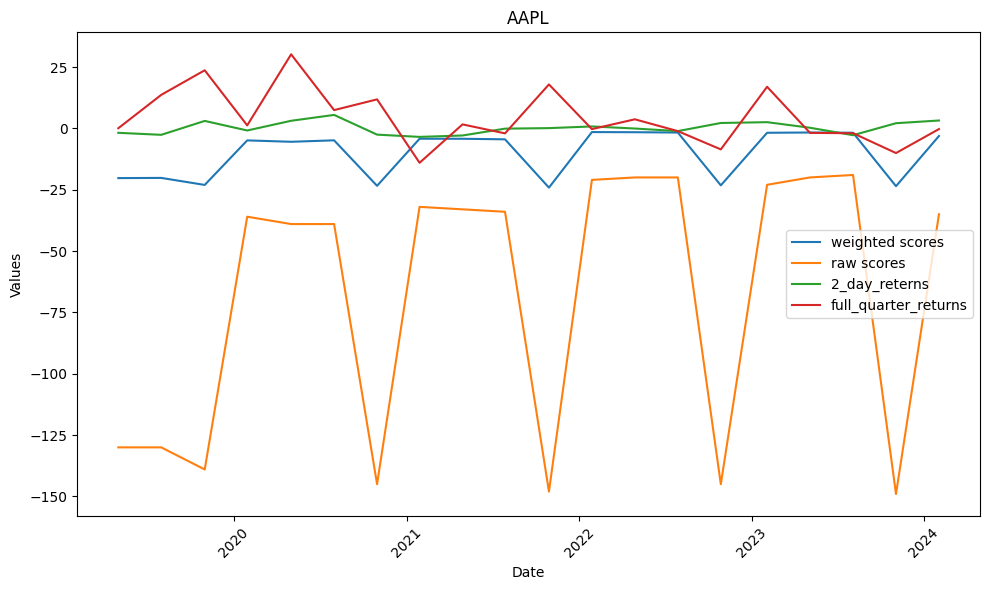

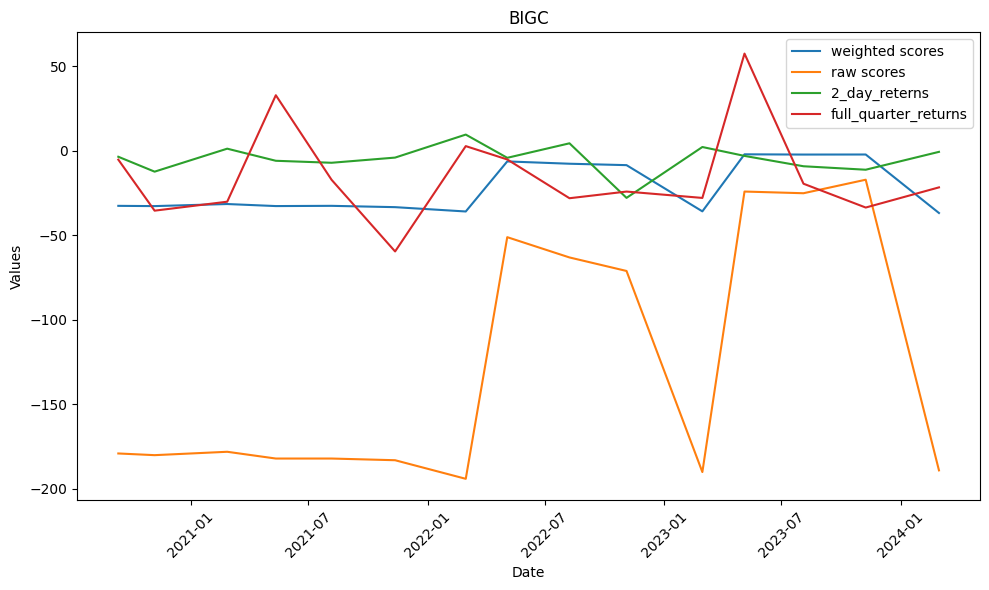

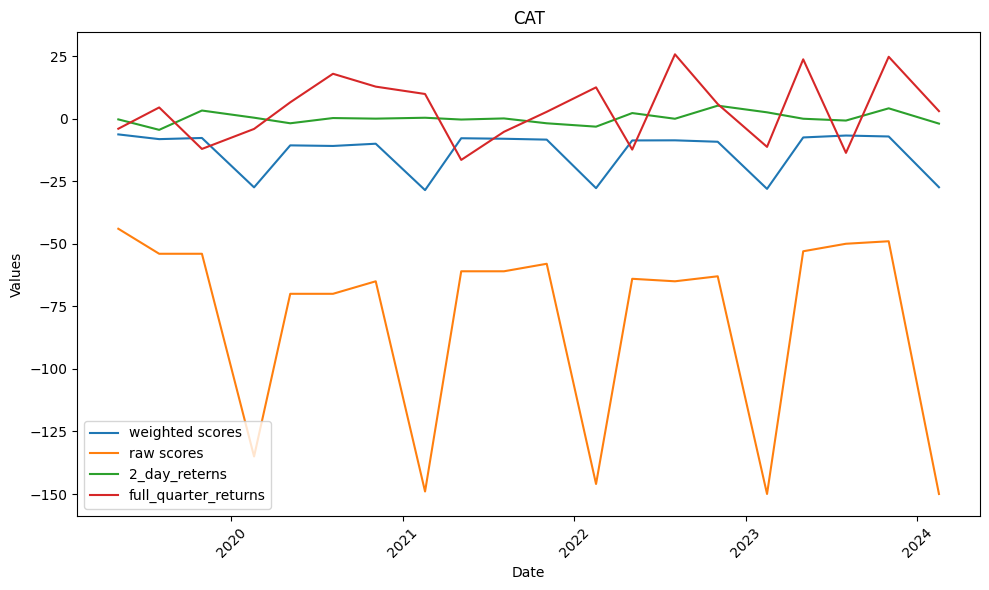

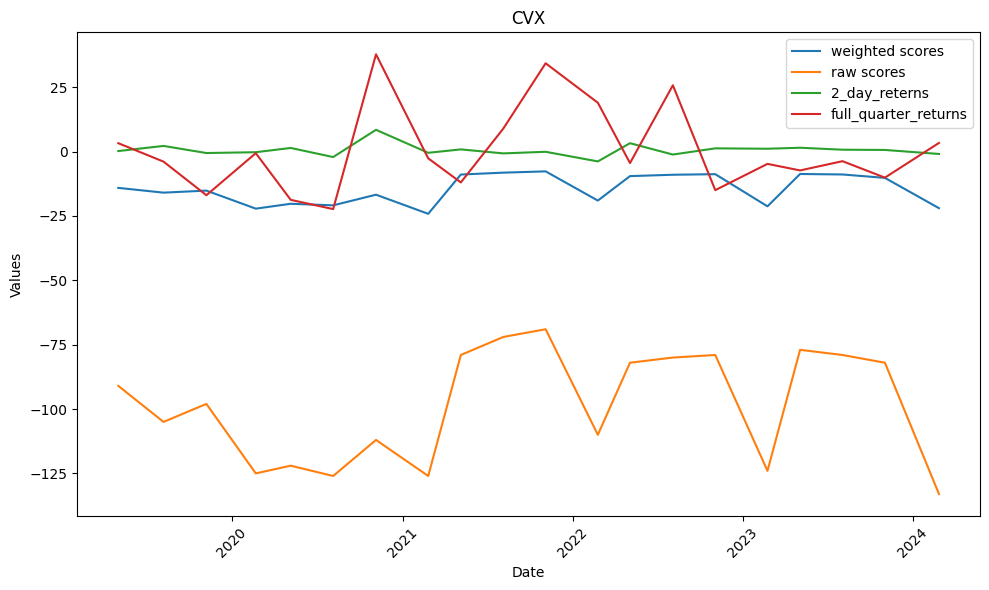

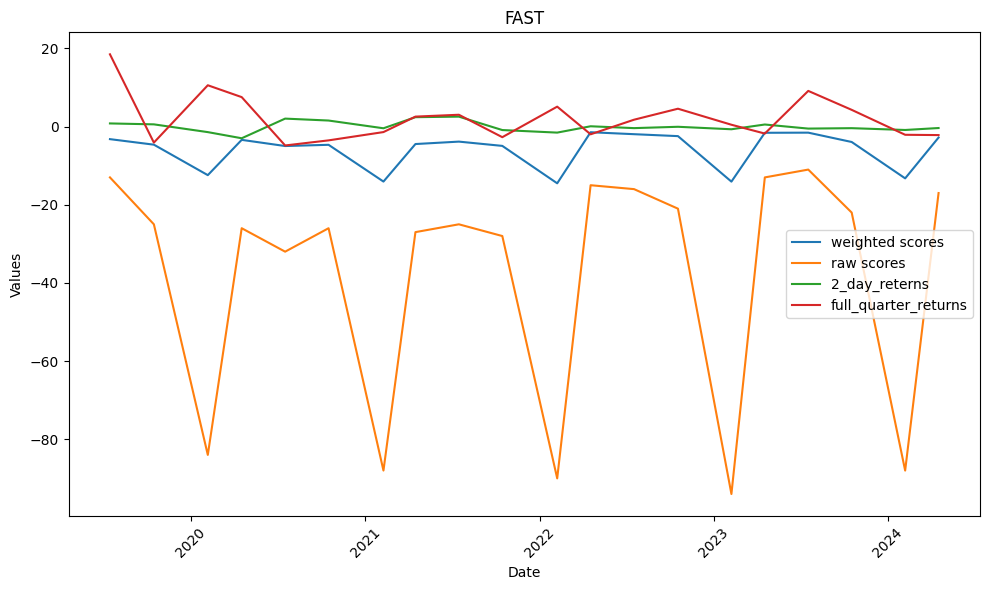

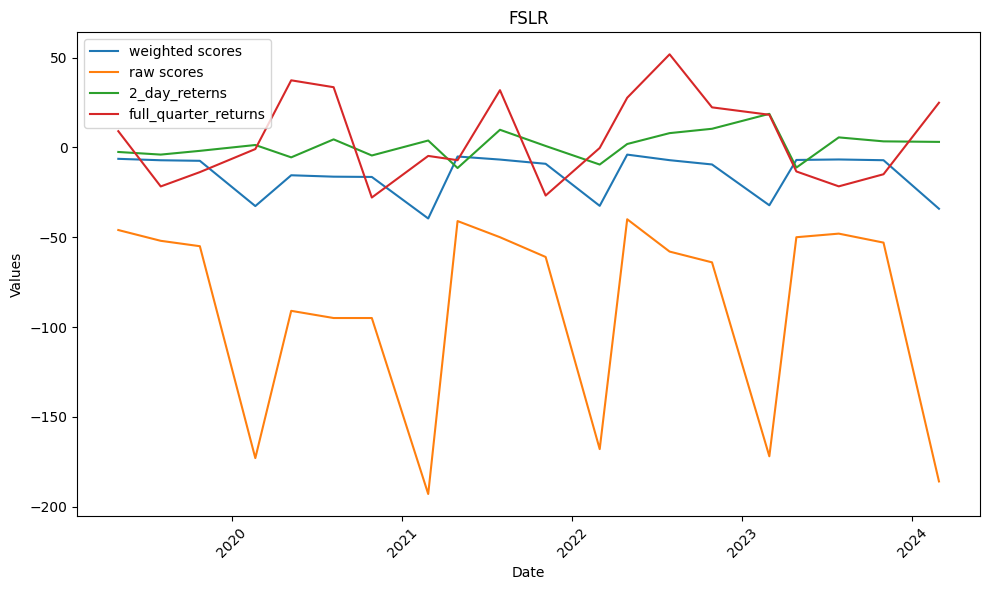

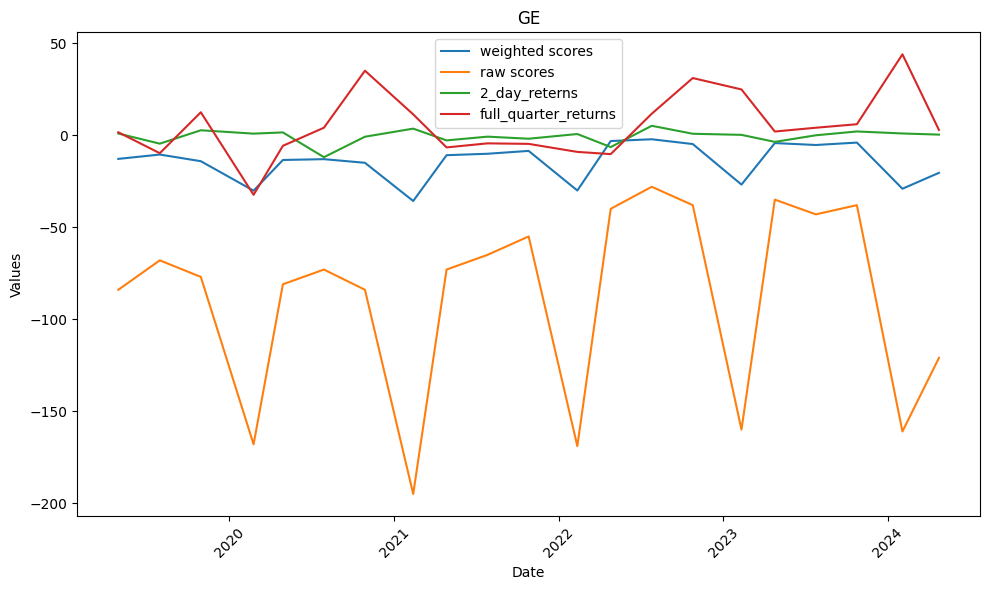

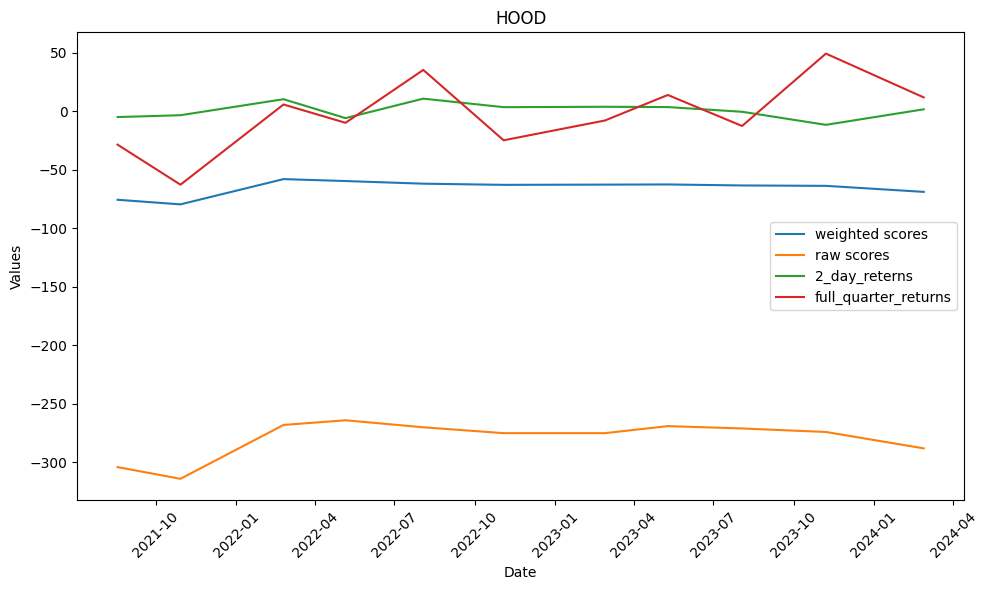

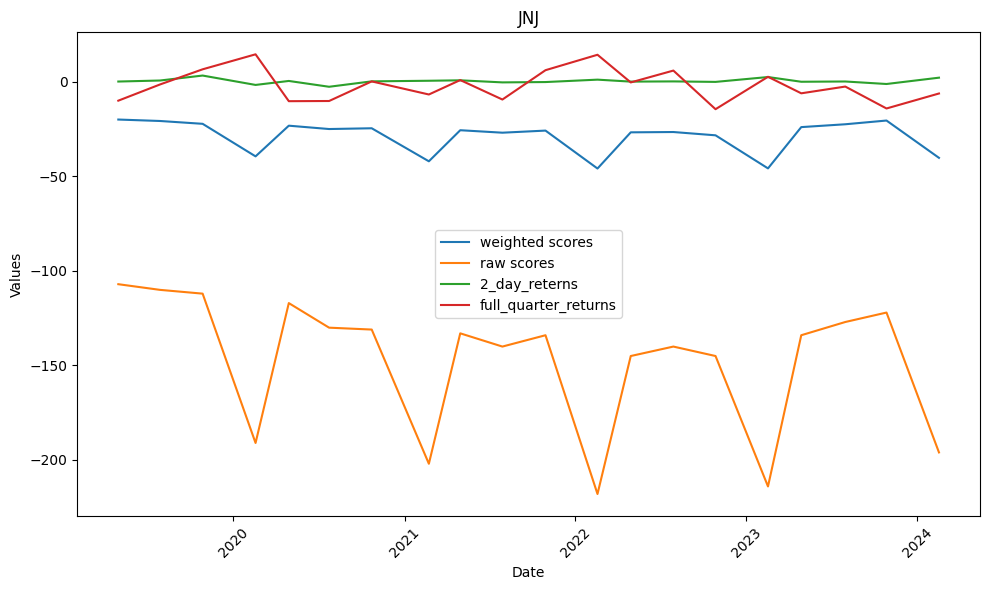

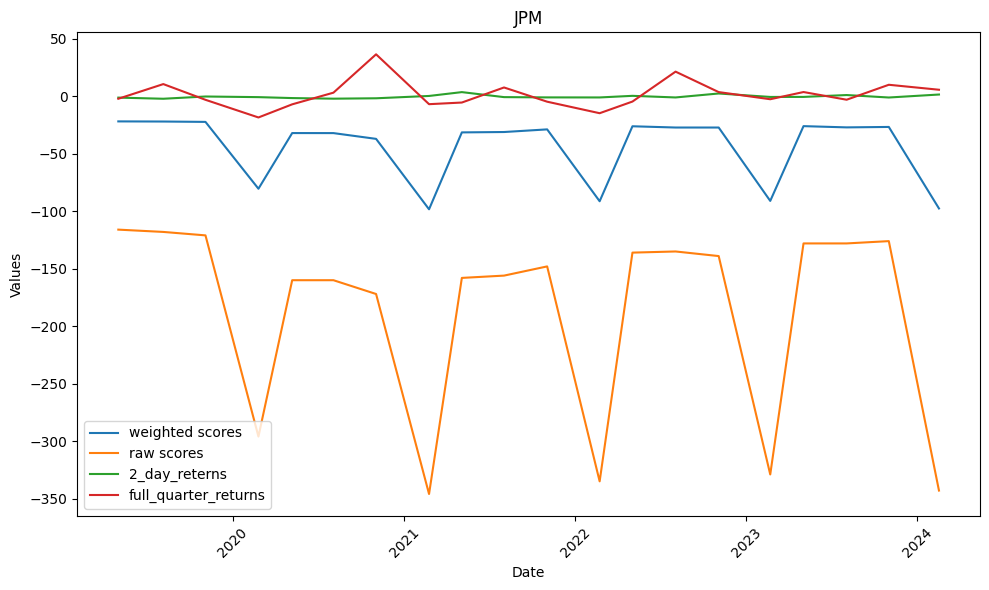

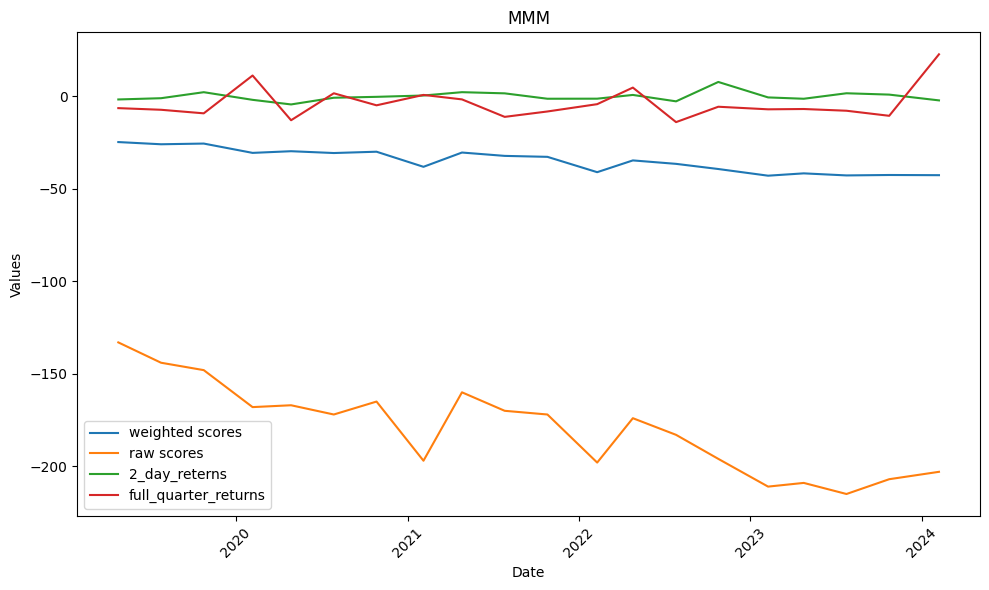

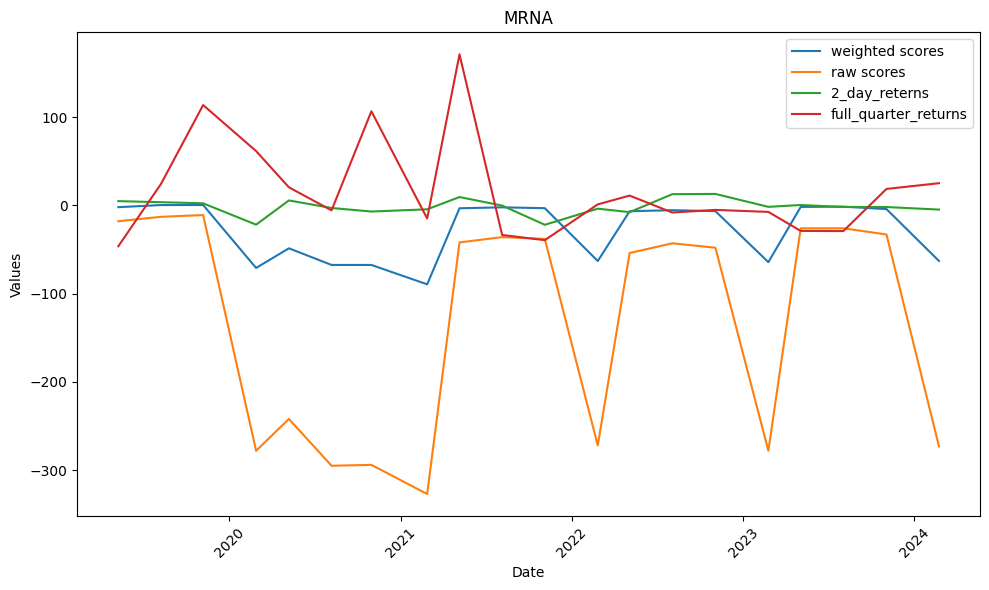

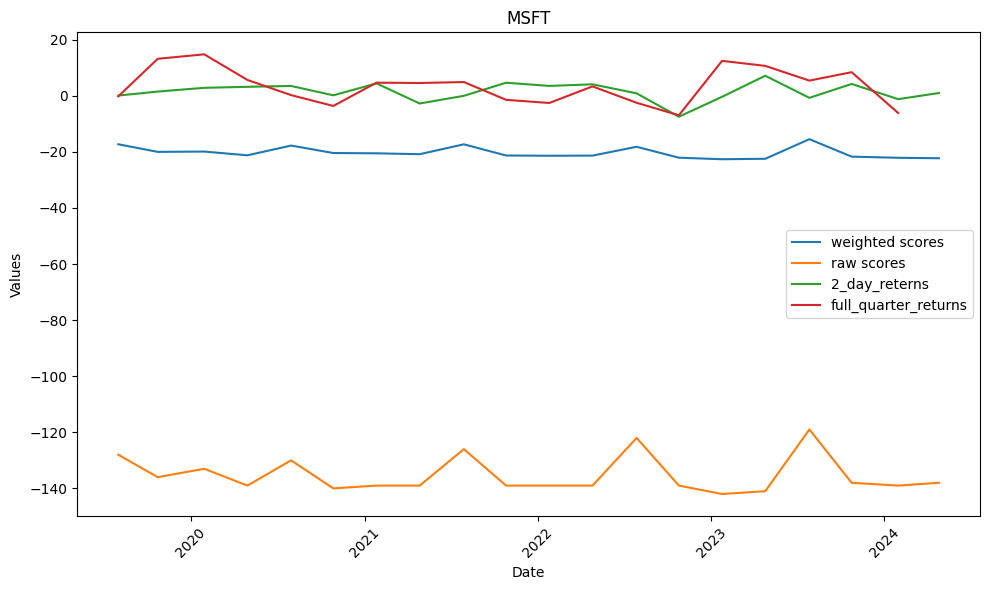

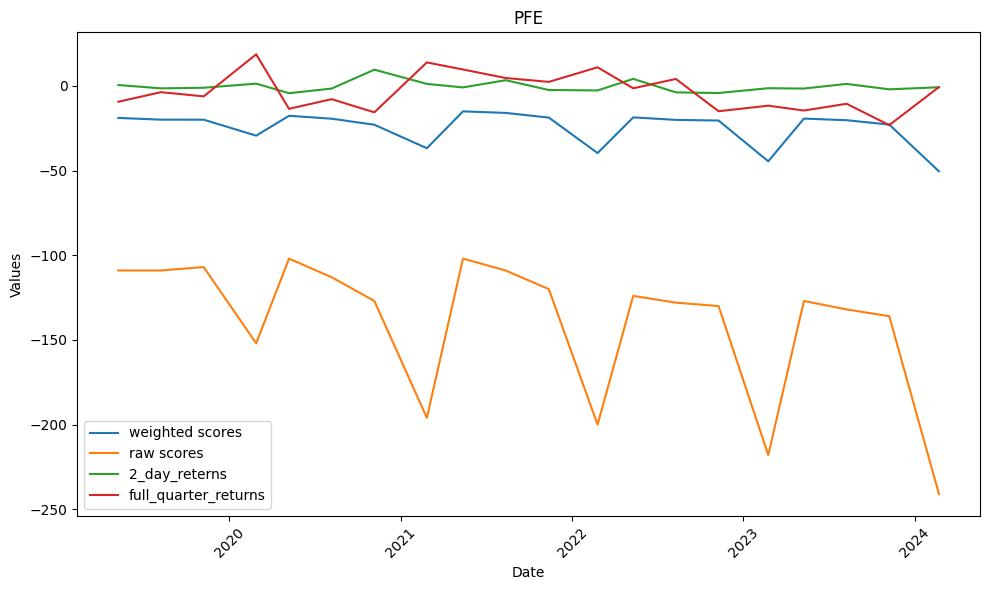

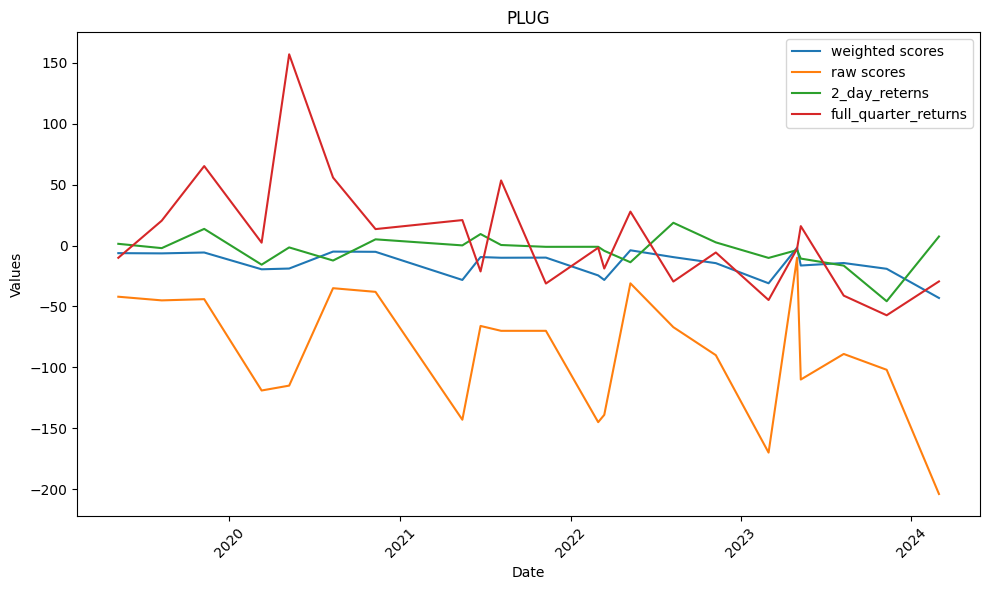

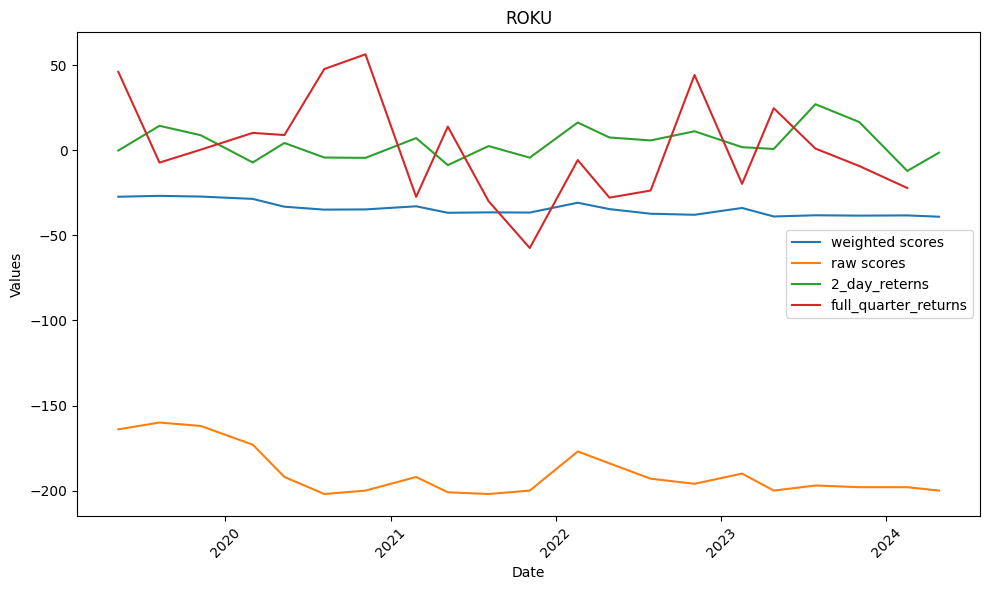

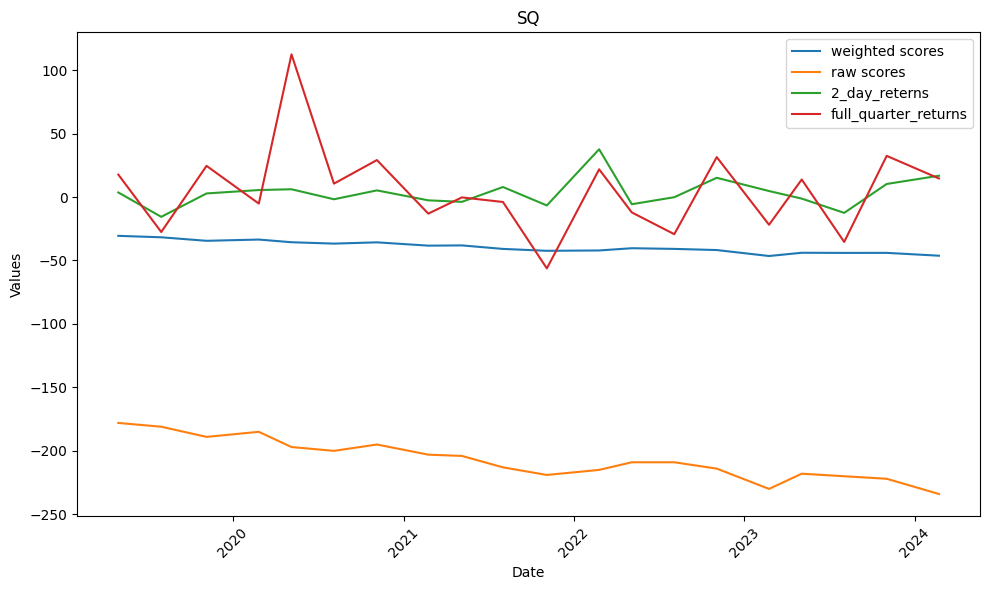

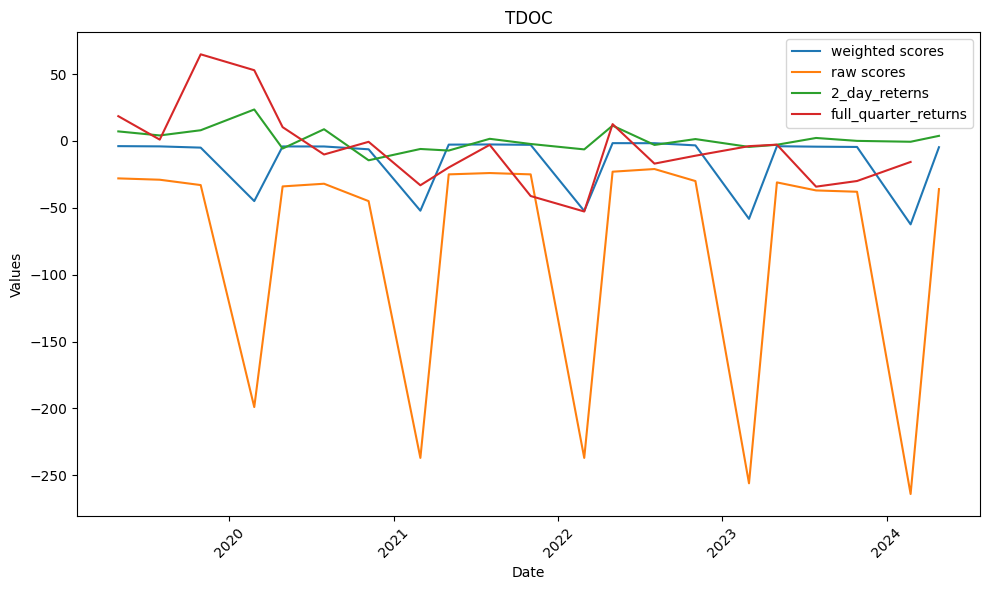

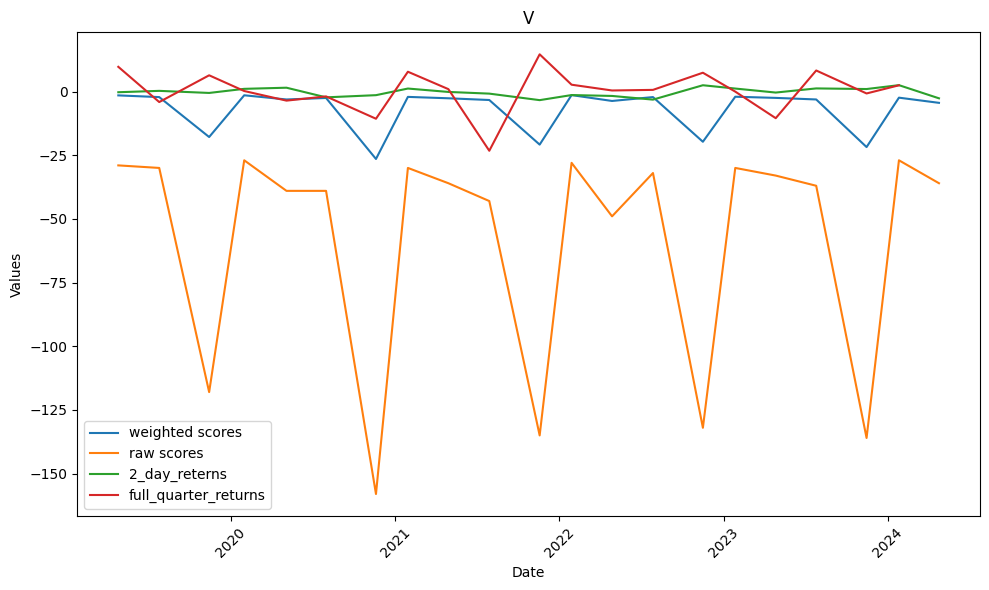

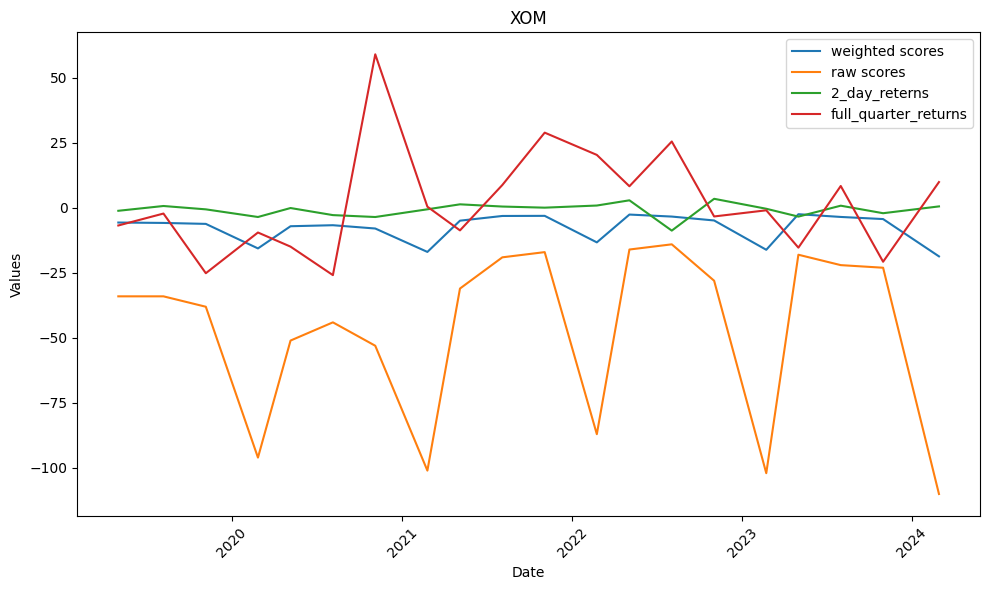

In [147]:
for company_name, scores in dict_for_anal.items():
   
    df_for_plt = scores.select(pl.exclude("row_names"))

    dates = [datetime.strptime(date, "%Y-%m-%d") for date in df_for_plt.columns]
   
    plt.figure(figsize=(10, 6))
    row_indices_to_plot = [0, 1, 4, -1]

    for idx in row_indices_to_plot:
        row = df_for_plt.row(idx, named=True)  
        plt.plot(dates, list(row.values()), label=scores.row(idx)[-1])

    plt.title(company_name)
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

At first glance some time series exhibits at least piecewise dependence. 

Next step is to regress each return on weighted, raw scores and polarity scores from Loughran-McDonald and Harvard dictionaries.

And also we can see that in cases of 10-K reports which are typicly much longer we can see strong pattern in raw scores which is smoothed in weighted scores. But still this pattern could be recognized. This can be interpreted as 10-K can contain more information about future prices

This func takes as input key-value pair (company name and dataframe with sentiment scores and returns), regress each retern (2_days, 3_days, etc) on weightes sentiment score ans raw sentiment score. Then it collects the slopes (beta-coefficient) of returns regressed on raw score and on weighted score in the separate polars series (in the loop they will be staked in dataframe)

In [175]:
def fit_regression(y, x):

    model = sm.OLS(y, x, missing='drop').fit()
    slope = model.params[1]
    
    return slope

In [180]:
def regression_slopes(company_df_woi, X_names, company_name="total_df"):
    
    # x_1 - weighted score
    # x_2 - raw score
    # x_3 - lm score
    # x_4 - harvard score

    X_values = [company_df_woi.row(x) for x in range(0, 4)]
    #print(X_values)
    
    
    #x_1 = company_df_woi.row(0)
    #x_2 = company_df_woi.row(1)
    #x_3 = company_df_woi.row(2)
    #x_4 = company_df_woi.row(3)

    #X_values = [x_1, x_2, x_3, x_4]
    #print(X_values)

    X = [sm.add_constant(x) for x in X_values]



    #x_1 = sm.add_constant(x_1)
    #x_2 = sm.add_constant(x_2)
    #x_3 = sm.add_constant(x_3)
    #x_4 = sm.add_constant(x_4)
    
    
    
    Y = [company_df_woi.row(y) for y in range(4, 11)]

    slopes_dict = {}

    for i, x in enumerate(X):

        name_of_score = X_names[i][0].split()[0]
        slopes_name = f'{name_of_score}_slopes'
        
        slopes = []
        for y in Y:
            slope = fit_regression(y, x)
            slopes.append(slope)

        slopes_dict[slopes_name] = pl.Series(company_name, slopes)
    
    #print(slopes_dict)
    
    #slopes_raw = []
    #for y in Y:
    #    
    #    model = sm.OLS(y, x_2, missing='drop').fit()
    #    slope = model.params[1]
    #    slopes_raw.append(slope)
    #
    #slopes_lm = []
    #for y in Y:
    #    
    #    model = sm.OLS(y, x_3, missing='drop').fit()
    #    slope = model.params[1]
    #    slopes_lm.append(slope)
#
    #slopes_harvard = []
    #for y in Y:
    #    slope = fit_regression(y, x_4)
    #    slopes_harvard.append(slope)
#
#
    #slopes_weighted = pl.Series(company_name, slopes_weighted)
    #slopes_raw = pl.Series(company_name, slopes_raw)
    #slopes_lm = pl.Series(company_name, slopes_lm)
    #slopes_harvard = pl.Series(company_name, slopes_harvard)
    

    return slopes_dict

This is the general loop that takes dict_for_anal() whith scores and returns and for each company in the dict it calculates two series: first one contain regression slopes for weighted scores and second one for raw scores. Serieses stacked in the separete dataframes (for raw and for weighted scores)

In [181]:
def compute_all_slopes(dict_for_anal):

    slopes_df_dict = {
        "weighted_slopes_df" : pl.DataFrame(),
        "raw_slopes_df" : pl.DataFrame(),
        "lm_slopes_df" : pl.DataFrame(),
        "harvard_slopes_df" : pl.DataFrame()
    }
    
    for company_name, company_df in dict_for_anal.items(): 

        X_names = [company_df.select(pl.col("row_names")).row(x) for x in range(0, 4)]

        company_df_woi = company_df.select(pl.exclude("row_names"))

        slopes_dict = regression_slopes(company_df_woi, X_names, company_name)

        

        for x in X_names:
            
            name_of_score = x[0].split()[0]
            slopes_name = f'{name_of_score}_slopes'
            
            df_name = f"{name_of_score}_slopes_df"
            #if slopes_dict.get(slopes_name) is not None:
            slopes_df_dict[df_name] = slopes_df_dict[df_name].hstack([slopes_dict[slopes_name]])

            #print(slopes_dict[slopes_name])
#
            #df_to_stack = slopes_df_dict[df_name]
            #df_to_stack.hstack([slopes_dict[slopes_name]])
            #print(df_to_stack)
            
            
            #weighted_slopes_df = weighted_slopes_df.hstack([slopes_dict[name_of_score]])
            #raw_slopes_df = raw_slopes_df.hstack([slopes_dict])
            #lm_slopes_df = lm_slopes_df.hstack([slopes_dict])
            #harvard_slopes_df = harvard_slopes_df.hstack([slopes_dict])

    return slopes_df_dict
        

In [182]:
slopes_df_dict = compute_all_slopes(dict_for_anal)

As an output from previous functions we have dataframes with regression slopes of different returns on raw, weighted scores and Loughran-McDonald and Harvard dictionaries. Each col of these dfs contain regression slopes for particular company. First row contain slope for 2_days return, second row contain slope for 3_days return, etc.  I have decided to check what is the proportion of positive regression slopes for each return timeframe (2_days, 3_days, etc). For that purpose i will transpose each of these dfs, apply condition > 0, then verticaly sum boolean values and obtain the prorortion of positive slopes for each time frame. 

In [184]:
def calc_efficiency_metrics(slopes_df):

    df_tranposed = slopes_df.transpose()

    res = df_tranposed.select(pl.all() > 0).sum()
    total_num_of_slopes = slopes_df.shape[1]

    positive_slopes = [res.select(pl.col(res.columns[x]).gather(0)).item() for x in range(slopes_df.shape[0])]

    for counter, x in enumerate(positive_slopes):
        print(f'Prorortion of positive {counter + 2}_day returns: {x/total_num_of_slopes}')
    
    

    

This loop apply calc_efficiency_metrics function to each item of slopes_df_dict where each item is a dataframe which regression slopes for each regressor.

In [ ]:
for key, slopes_df in slopes_df_dict.items():
    print(f'Metrics for: {key}')
    calc_efficiency_metrics(slopes_df)
    

Positive slopes means that sentiment scores and returns mooves in the same direction (hense, they are working as predictors of stock price movement). As the result of this preliminary analisis we can say that sentiment scores of 10-Q reports are not very good predictors of stock movments. Positive proportion of this slopes are close to 0.5, which means that on average in our sample there are 50/50 chance that scores and returns are mooving in the same direction.

As we can see that, despite visual conclusion that weighted scores are more "smooth", they barely outperform raw scores, but at least they are not worse, meaning that at each time frame (except 5_days) the proportion of positive regression slopes of weighted scores => proportion of positive regression slopes of raw scores.

This func stackes all data in one df, and calculate the single slope for each time frame

In [35]:
def compute_signl_slope(dict_for_anal):

    total_df = pl.DataFrame()
    
    for company_name, company_df in dict_for_anal.items(): 
    
        company_df = company_df.select(pl.exclude("row_names"))
        
        company_df = company_df.rename({col: f"{col}_{company_name}" for col in company_df.columns})

        total_df = total_df.hstack(company_df)
    
    slope_weighted, slope_raw, slope_lm, slope_harvard = regression_slopes(total_df)

    return slope_weighted, slope_raw, slope_lm, slope_harvard

In [36]:
slopes_weighted, slopes_raw, slopes_lm, slopes_harvard = compute_signl_slope(dict_for_anal)

In [37]:
print(f' slopes_weighted: {slopes_weighted}, slopes_raw: {slopes_raw}, slopes_lm: {slopes_lm}, slopes_harvard: {slopes_harvard}')

 slopes_weighted: shape: (7,)
Series: 'total_df' [f64]
[
	-0.009537
	0.017868
	0.027616
	0.021722
	0.021401
	0.010745
	0.06722
], slopes_raw: shape: (7,)
Series: 'total_df' [f64]
[
	-0.00411
	0.002284
	0.004373
	0.002886
	0.002626
	0.000149
	0.015163
], slopes_lm: shape: (7,)
Series: 'total_df' [f64]
[
	0.330616
	1.179053
	1.02975
	1.786038
	1.610909
	1.634859
	18.028693
], slopes_harvard: shape: (7,)
Series: 'total_df' [f64]
[
	-3.739671
	0.576719
	4.261854
	3.209666
	4.483385
	3.945624
	16.088036
]


jupyter nbconvert --to pdf Parsim-sec\src\Analysis\YFiin_excess_returns.ipynb

jupyter nbconvert --to html Parsim-sec\src\Analysis\YFiin_excess_returns.ipynb

